In [1]:
import os
import sys

import pylab as pl

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark import SparkContext, SparkConf

#We can create a SparkConf() object and use it to initialize the spark context
conf = SparkConf().setAppName("Notebook 1").setMaster("local[4]") #Initialize spark context using 4 local cores as workers
sc = SparkContext(conf=conf)    

from pyspark.rdd import RDD

23/11/23 19:14:18 WARN Utils: Your hostname, abdou-Nitro-AN515-55 resolves to a loopback address: 127.0.1.1; using 10.188.49.204 instead (on interface wlp0s20f3)
23/11/23 19:14:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/23 19:14:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def pretty_print_plan(rdd):
    for x in rdd.toDebugString().decode().split('\n'):
        print(x)

## The Moby Dick text

![MobyDick](https://m.media-amazon.com/images/I/91xMMAxMS1L._SL1500_.jpg)

And so begins an incredible odyssey that will take ship, sailors and readers to the edge of darkness. Moby Dick" is an epic tragedy of terrible dramatic power, the endless, desperate quest of the captain of a drunken ship on a voyage of no return.

### Words Count

In [3]:
%%time
text_file = sc.textFile("../data/mobydick.txt")
type(text_file)

CPU times: user 537 µs, sys: 1.34 ms, total: 1.87 ms
Wall time: 598 ms


pyspark.rdd.RDD

In [4]:
%%time
words = text_file.flatMap(lambda line: line.split(" "))

CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 16.3 ms


In [5]:
%%time
not_empty = words.filter(lambda x: x!="")

CPU times: user 111 µs, sys: 0 ns, total: 111 µs
Wall time: 134 µs


In [6]:
%%time
key_val = not_empty.map(lambda x: (x, 1))
counts= key_val.reduceByKey(lambda x1, x2: x1+x2)

CPU times: user 9.71 ms, sys: 0 ns, total: 9.71 ms
Wall time: 123 ms


In [7]:
%%time
## get the number of different words
diff_words = counts.count()
## get the number of words
nb_words = counts.map(lambda x: x[1]).reduce(lambda x, y: x+y)

print(f"number of different words = {diff_words} number of words = {nb_words} nb of occurence per word = {round(nb_words / diff_words, 2)}")

number of different words = 19840 number of words = 115314 nb of occurence per word = 5.81
CPU times: user 18.7 ms, sys: 2.11 ms, total: 20.8 ms
Wall time: 2.04 s


### Most common words

In [8]:
%%time
## Pythonic way
p_data = counts.collect()

CPU times: user 9.27 ms, sys: 2.01 ms, total: 11.3 ms
Wall time: 122 ms


In [9]:
%%time
p_data.sort(key=lambda x: x[1])
print("Most common words in Moby Dick:\n\n"+"\n".join(['%s:\t%d'%c for c in reversed(p_data[-5:])]))

Most common words in Moby Dick:

the:	6611
of:	3460
and:	2969
a:	2466
to:	2339
CPU times: user 2.43 ms, sys: 0 ns, total: 2.43 ms
Wall time: 2.42 ms


We can do the stuff on the head node using old python methods but... it doesn't scale if we have HUGE Data

---

We are gonna use PySpark RDDs to add this scalable feature

In [10]:
%%time
# spark way
reversed_counts = counts.map(lambda x: (x[1], x[0]))
sorted_counts = reversed_counts.sortByKey(ascending=False)

CPU times: user 13.3 ms, sys: 4.94 ms, total: 18.2 ms
Wall time: 289 ms


In [11]:
## Execution plan of the ops
pretty_print_plan(sorted_counts)

(2) PythonRDD[15] at RDD at PythonRDD.scala:53 []
 |  MapPartitionsRDD[14] at mapPartitions at PythonRDD.scala:160 []
 |  ShuffledRDD[13] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(2) PairwiseRDD[12] at sortByKey at <timed exec>:3 []
    |  PythonRDD[11] at sortByKey at <timed exec>:3 []
    |  MapPartitionsRDD[5] at mapPartitions at PythonRDD.scala:160 []
    |  ShuffledRDD[4] at partitionBy at NativeMethodAccessorImpl.java:0 []
    +-(2) PairwiseRDD[3] at reduceByKey at <timed exec>:2 []
       |  PythonRDD[2] at reduceByKey at <timed exec>:2 []
       |  ../data/mobydick.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 []
       |  ../data/mobydick.txt HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 []


In [12]:
%%time
## Now we come back to the head node bc we need the data now
first_10 = sorted_counts.take(10)
print("MOst 10 common words in Moby Dick:\n"+"\n".join([f"{k}\t:\t\t\t{v}" for (v, k) in first_10]))

MOst 10 common words in Moby Dick:
the	:			6611
of	:			3460
and	:			2969
a	:			2466
to	:			2339
in	:			1969
;	:			1949
that	:			1430
his	:			1275
I	:			1180
CPU times: user 6.11 ms, sys: 0 ns, total: 6.11 ms
Wall time: 161 ms


#### To sum up

- An RDD is a distributed immutable array and is the core data structure of Spark
- It is not possible to operate on RDD directly but through **Transformations** and **Actions**
- **Transformations** transform an RDD into another RDD
- **Actions** output their results on the head node
- After the action is done you are now using the head node and no longer on the workers node.
- RDD operations (**Transformations** and **Actions**) are added to what we call an **Execution Plan**
- The plan is executed when the result is needed
- It is possible to store intermediate result explicitly by using caching
- For scalability you need to use RDDs instead of working only on the head node (Ex: finding the most common words)

## Meteorological data

In [13]:
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
%pylab inline

sqlContext = SQLContext(sc)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/abdou/anaconda3/envs/pyspark-env/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [14]:
data_path = "../data/NY.parquet"

df = sqlContext.read.load(data_path)

df.printSchema()

root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- dist_coast: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)


In [15]:
df.show(1)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+


#### describe columns

In [16]:
df.describe(df.columns).show()

23/11/23 19:14:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------+-----------+------------------+-------------------+------------------+------------------+------------------+------+---------------+
|summary|    Station|Measurement|              Year|         dist_coast|          latitude|         longitude|         elevation| state|           name|
+-------+-----------+-----------+------------------+-------------------+------------------+------------------+------------------+------+---------------+
|  count|     168398|     168398|            168398|             168398|            168398|            168398|            168398|168398|         168398|
|   mean|       NULL|       NULL|1963.4289124573927| 245.78455113006692|  42.6842968505041| -75.4551864389521| 245.2899639266881|  NULL|           NULL|
| stddev|       NULL|       NULL| 30.58676603214533|  129.9711278397269|1.0492530244970495|1.7907915903419556|189.69342701097085|  NULL|           NULL|
|    min|USC00300015|       PRCP|              1871|0.04799420014023781| 39.799999

#### group by

In [17]:
df.groupby('measurement').agg({'year': "min", 'station': "count"}).show()

+-----------+---------+--------------+
|measurement|min(year)|count(station)|
+-----------+---------+--------------+
|   TMIN_s20|     1873|         13442|
|       TMIN|     1873|         13442|
|   SNOW_s20|     1884|         15629|
|       TOBS|     1876|         10956|
|   SNWD_s20|     1888|         14617|
|   PRCP_s20|     1871|         16118|
|   TOBS_s20|     1876|         10956|
|       TMAX|     1873|         13437|
|       SNOW|     1884|         15629|
|   TMAX_s20|     1873|         13437|
|       SNWD|     1888|         14617|
|       PRCP|     1871|         16118|
+-----------+---------+--------------+


In [18]:
L = df.groupby('measurement').count().collect()
L

[Row(measurement='TMIN_s20', count=13442),
 Row(measurement='TMIN', count=13442),
 Row(measurement='SNOW_s20', count=15629),
 Row(measurement='TOBS', count=10956),
 Row(measurement='SNWD_s20', count=14617),
 Row(measurement='PRCP_s20', count=16118),
 Row(measurement='TOBS_s20', count=10956),
 Row(measurement='TMAX', count=13437),
 Row(measurement='SNOW', count=15629),
 Row(measurement='TMAX_s20', count=13437),
 Row(measurement='SNWD', count=14617),
 Row(measurement='PRCP', count=16118)]

In [19]:
D = [(e.measurement, e["count"]) for e in L]
sorted(D,key= lambda c: c[1], reverse=True)

[('PRCP_s20', 16118),
 ('PRCP', 16118),
 ('SNOW_s20', 15629),
 ('SNOW', 15629),
 ('SNWD_s20', 14617),
 ('SNWD', 14617),
 ('TMIN_s20', 13442),
 ('TMIN', 13442),
 ('TMAX', 13437),
 ('TMAX_s20', 13437),
 ('TOBS', 10956),
 ('TOBS_s20', 10956)]

In [20]:
sqlContext.registerDataFrameAsTable(df, "weatherTable") ## so that we can query on weatherTable like in old SQL

In [21]:
query = """
SELECT measurement, COUNT(measurement) as count,
        MIN(year) as MinYear
FROM weatherTable
GROUP BY measurement
ORDER BY count
"""

print(query)
print("================================RESULT================================")
print()
sqlContext.sql(query).show()


SELECT measurement, COUNT(measurement) as count,
        MIN(year) as MinYear
FROM weatherTable
GROUP BY measurement
ORDER BY count

================================RESULT================================
+-----------+-----+-------+
|measurement|count|MinYear|
+-----------+-----+-------+
|       TOBS|10956|   1876|
|   TOBS_s20|10956|   1876|
|       TMAX|13437|   1873|
|   TMAX_s20|13437|   1873|
|   TMIN_s20|13442|   1873|
|       TMIN|13442|   1873|
|   SNWD_s20|14617|   1888|
|       SNWD|14617|   1888|
|   SNOW_s20|15629|   1884|
|       SNOW|15629|   1884|
|   PRCP_s20|16118|   1871|
|       PRCP|16118|   1871|
+-----------+-----+-------+


#### projection

In [22]:
df.select("dist_coast", 'Values', 'Year').show()

+-----------------+--------------------+----+
|       dist_coast|              Values|Year|
+-----------------+--------------------+----+
|361.8320007324219|[00 00 00 00 00 0...|1945|
|361.8320007324219|[99 46 52 46 0B 4...|1946|
|361.8320007324219|[79 4C 75 4C 8F 4...|1947|
|361.8320007324219|[72 48 7A 48 85 4...|1948|
|361.8320007324219|[BB 49 BC 49 BD 4...|1949|
|361.8320007324219|[6E 4B 93 4B BB 4...|1950|
|361.8320007324219|[27 4A 32 4A 28 4...|1951|
|361.8320007324219|[54 4B 60 4B 6A 4...|1952|
|361.8320007324219|[48 4A 37 4A 28 4...|1953|
|361.8320007324219|[DE 4A D4 4A CA 4...|2000|
|361.8320007324219|[D9 44 C7 44 B6 4...|2001|
|361.8320007324219|[CF 4B B8 4B A1 4...|2002|
|361.8320007324219|[18 4B F1 4A D2 4...|2003|
|361.8320007324219|[CE 4A 9C 4A 6B 4...|2004|
|361.8320007324219|[DD 4C D3 4C C9 4...|2005|
|361.8320007324219|[91 4B 9F 4B AC 4...|2006|
|361.8320007324219|[39 4E 36 4E 34 4...|2007|
|361.8320007324219|[3A 4A 11 4A EA 4...|2008|
|361.8320007324219|[5C 4A 3F 4A 26

#### filter

In [23]:
df.filter((df.Year==1945 ) & (df.name=="DANSVILLE MUNI AP")).show()

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   TMAX_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   SNOW_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   TMIN_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   

#### filter and projection

In [24]:
df.filter((df.Year==1945 ) & (df.name=="DANSVILLE MUNI AP")).select("Station", "latitude", "longitude", "name").show()

+-----------+--------------+------------------+-----------------+
|    Station|      latitude|         longitude|             name|
+-----------+--------------+------------------+-----------------+
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
|USW00094704|42.57080078125|-77.71330261230469|DANSVILLE MUNI AP|
+-----------+--------------+------------------+-----------------+


### Mapping over dataframe

To perform a map operation on a DataFrame you need to transform it into an RDD before.. But this is a wrong way to do it.

A better way to do it is to use built-in sparkSQL functions directly or register new ones.

In [25]:
# Wrong way to do
df.rdd.map(lambda row: (row.longitude, row.latitude)).take(5)

[(-77.71330261230469, 42.57080078125),
 (-77.71330261230469, 42.57080078125),
 (-77.71330261230469, 42.57080078125),
 (-77.71330261230469, 42.57080078125),
 (-77.71330261230469, 42.57080078125)]

### Aggregations


* **Aggregation** can be used, in combination with built-in sparkSQL functions 
to compute statistics of a dataframe.
* computation will be fast thanks to combined optimzations with database operations.

In [26]:
import pyspark.sql.functions as F

In [27]:
# How many distinct stations do we have?
df.agg({'station':'approx_count_distinct'}).show()

+------------------------------+
|approx_count_distinct(station)|
+------------------------------+
|                           339|
+------------------------------+


### QUantile approximation

* Suppose we want to partition the years into 10 ranges
* such that in each range we have approximately the same number of records.
* The method `.approxQuantile` will use a sample to do this for us.

In [28]:
print("with accuracy 0.1", df.approxQuantile('Year', [0.1*i for i in range(1,10)], 0.1))
print("with accuracy 0.01", df.approxQuantile('Year', [0.1*i for i in range(1,10)], 0.01))

with accuracy 0.1 [1871.0, 1926.0, 1947.0, 1957.0, 1958.0, 1966.0, 1979.0, 1985.0, 2013.0]
with accuracy 0.01 [1917.0, 1936.0, 1948.0, 1957.0, 1965.0, 1974.0, 1983.0, 1992.0, 2002.0]


### collect the exact number of rows for each year

In [29]:
### Querying the number of rows for each year

query = """
SELECT year, COUNT(year) as NbYear
FROM weatherTable
GROUP BY year
ORDER BY year
"""

counts = sqlContext.sql(query)

print(counts)

DataFrame[year: bigint, NbYear: bigint]


In [30]:
counts.show()

+----+------+
|year|NbYear|
+----+------+
|1871|     2|
|1872|     2|
|1873|     6|
|1874|     6|
|1875|     6|
|1876|    14|
|1877|    14|
|1878|    14|
|1879|    14|
|1880|    14|
|1881|    14|
|1882|    14|
|1883|    14|
|1884|    16|
|1885|    22|
|1886|    24|
|1887|    24|
|1888|    40|
|1889|    24|
|1890|    34|
+----+------+


In [31]:
!pip install pandas

<Axes: xlabel='year'>

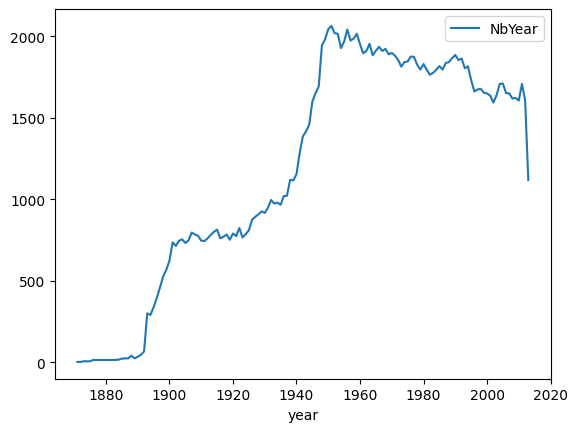

In [32]:
import pandas as pd

A = counts.toPandas()
A.plot.line("year", "NbYear")

### Reading rows selectively
Suppose we are only interested in snow measurements. We can apply an SQL query directly to the 
parquet files. As the data is organized in columnar structure, we can do the selection efficiently without loading the whole file to memory.

Here the file is small, but in real applications it can consist of hundreds of millions of records. In such cases loading the data first to memory and then filtering it is very wasteful.

In [33]:
data_path = "../data"
query = """
SELECT station, measurement, year
FROM parquet.`%s.parquet`
WHERE measurement=\"SNOW\"
"""%(data_path+"/NY")
print(query)
print("----------------------------------------------------------------")
df = sqlContext.sql(query).toPandas()

print(df.shape, df.columns)
df.head()


SELECT station, measurement, year
FROM parquet.`../data/NY.parquet`
WHERE measurement="SNOW"

----------------------------------------------------------------
(15629, 3) Index(['station', 'measurement', 'year'], dtype='object')


,station,measurement,year
0,USC00308600,SNOW,1932
1,USC00308600,SNOW,1956
2,USC00308600,SNOW,1957
3,USC00308600,SNOW,1958
4,USC00308600,SNOW,1959


## Meteorological Data Part 2

US weather data

In [34]:
data_path = "../data/US_state_weather.parquet"

### Number of records for each measurement

In [35]:
%%time
q = f"""
SELECT measurement, COUNT(*) as m_count
FROM parquet.`{data_path}`
GROUP BY measurement
"""
m_count_df = sqlContext.sql(q).toPandas()

CPU times: user 6.47 ms, sys: 5.69 ms, total: 12.2 ms
Wall time: 1.07 s


In [36]:
m_count_df.shape

(133, 2)

In [37]:
%%time
m_count_df.sort_values("m_count", ascending=False).reset_index(drop=True).head()

CPU times: user 816 µs, sys: 553 µs, total: 1.37 ms
Wall time: 1.28 ms


,measurement,m_count
0,PRCP,1171396
1,SNOW,1051466
2,SNWD,899553
3,TMAX,687240
4,TMIN,687227


#### Select the 30 most common measurements using sql

In [38]:
%%time
top30=list(m_count_df.sort_values('m_count', ascending=False).iloc[:30]['measurement'])
top30_str = f'measurement=\'{top30[0]}\'\n'
for m in top30[1:]:
    top30_str += f"\tor measurement=\'{m}\'\n"

q=f"""
SELECT *
FROM parquet.`{data_path}`
WHERE ({top30_str})
"""
print(q)
weather_df = sqlContext.sql(q)
print('number of records=', weather_df.count())


SELECT *
FROM parquet.`../data/US_state_weather.parquet`
WHERE (measurement='PRCP'
	or measurement='SNOW'
	or measurement='SNWD'
	or measurement='TMAX'
	or measurement='TMIN'
	or measurement='TOBS'
	or measurement='WT03'
	or measurement='MDPR'
	or measurement='WT01'
	or measurement='DAPR'
	or measurement='WT04'
	or measurement='WT05'
	or measurement='WT11'
	or measurement='WT06'
	or measurement='WESD'
	or measurement='WESF'
	or measurement='WT16'
	or measurement='TAVG'
	or measurement='WT08'
	or measurement='WT18'
	or measurement='WT14'
	or measurement='PGTM'
	or measurement='WT09'
	or measurement='WT02'
	or measurement='AWND'
	or measurement='EVAP'
	or measurement='WDMV'
	or measurement='WDF2'
	or measurement='WSF2'
	or measurement='WSF5'
)


number of records= 7410400
CPU times: user 12.1 ms, sys: 46 µs, total: 12.2 ms
Wall time: 1.71 s


### Count the number of undefined days

We want to know the distribution of the number of undefined entries, grouped by measurement type

In [39]:
import numpy as np

def unpackArray(x, data_type=np.int16):
    return np.frombuffer(x, dtype=data_type)
def count_nan(V):
    A = unpackArray(V, data_type=np.float16)
    return int(sum(np.isnan(A)))

In [40]:
# user defined function
from pyspark.sql.functions import udf

count_nan_udf = udf(count_nan, IntegerType())

# add nan column
weather_df = weather_df.withColumn("nan_no", count_nan_udf(weather_df.Values))

In [41]:
nan_rdd = weather_df.rdd

### let's compute histogram

We want to know for each type of measurements, the distribution of the number of nan entries (0-365).

> #### Histograms Using map and reduce
> We map each count (1-365) to a vector of 365 zeros with a single 1 at location “count”
We create a histogram by adding the vectors.(reduceByKey())

In [42]:
def map_to_hist(n):
    a = np.zeros(367)
    a[n] = 1
    return a

by_measurement = nan_rdd.map(lambda row: (row.Measurement, map_to_hist(row.nan_no)))

In [43]:
%%time
hist = by_measurement.reduceByKey(lambda x, y: x+y).collect()

CPU times: user 45.8 ms, sys: 22.4 ms, total: 68.2 ms
Wall time: 1min 29s


In [44]:
len(hist)

30

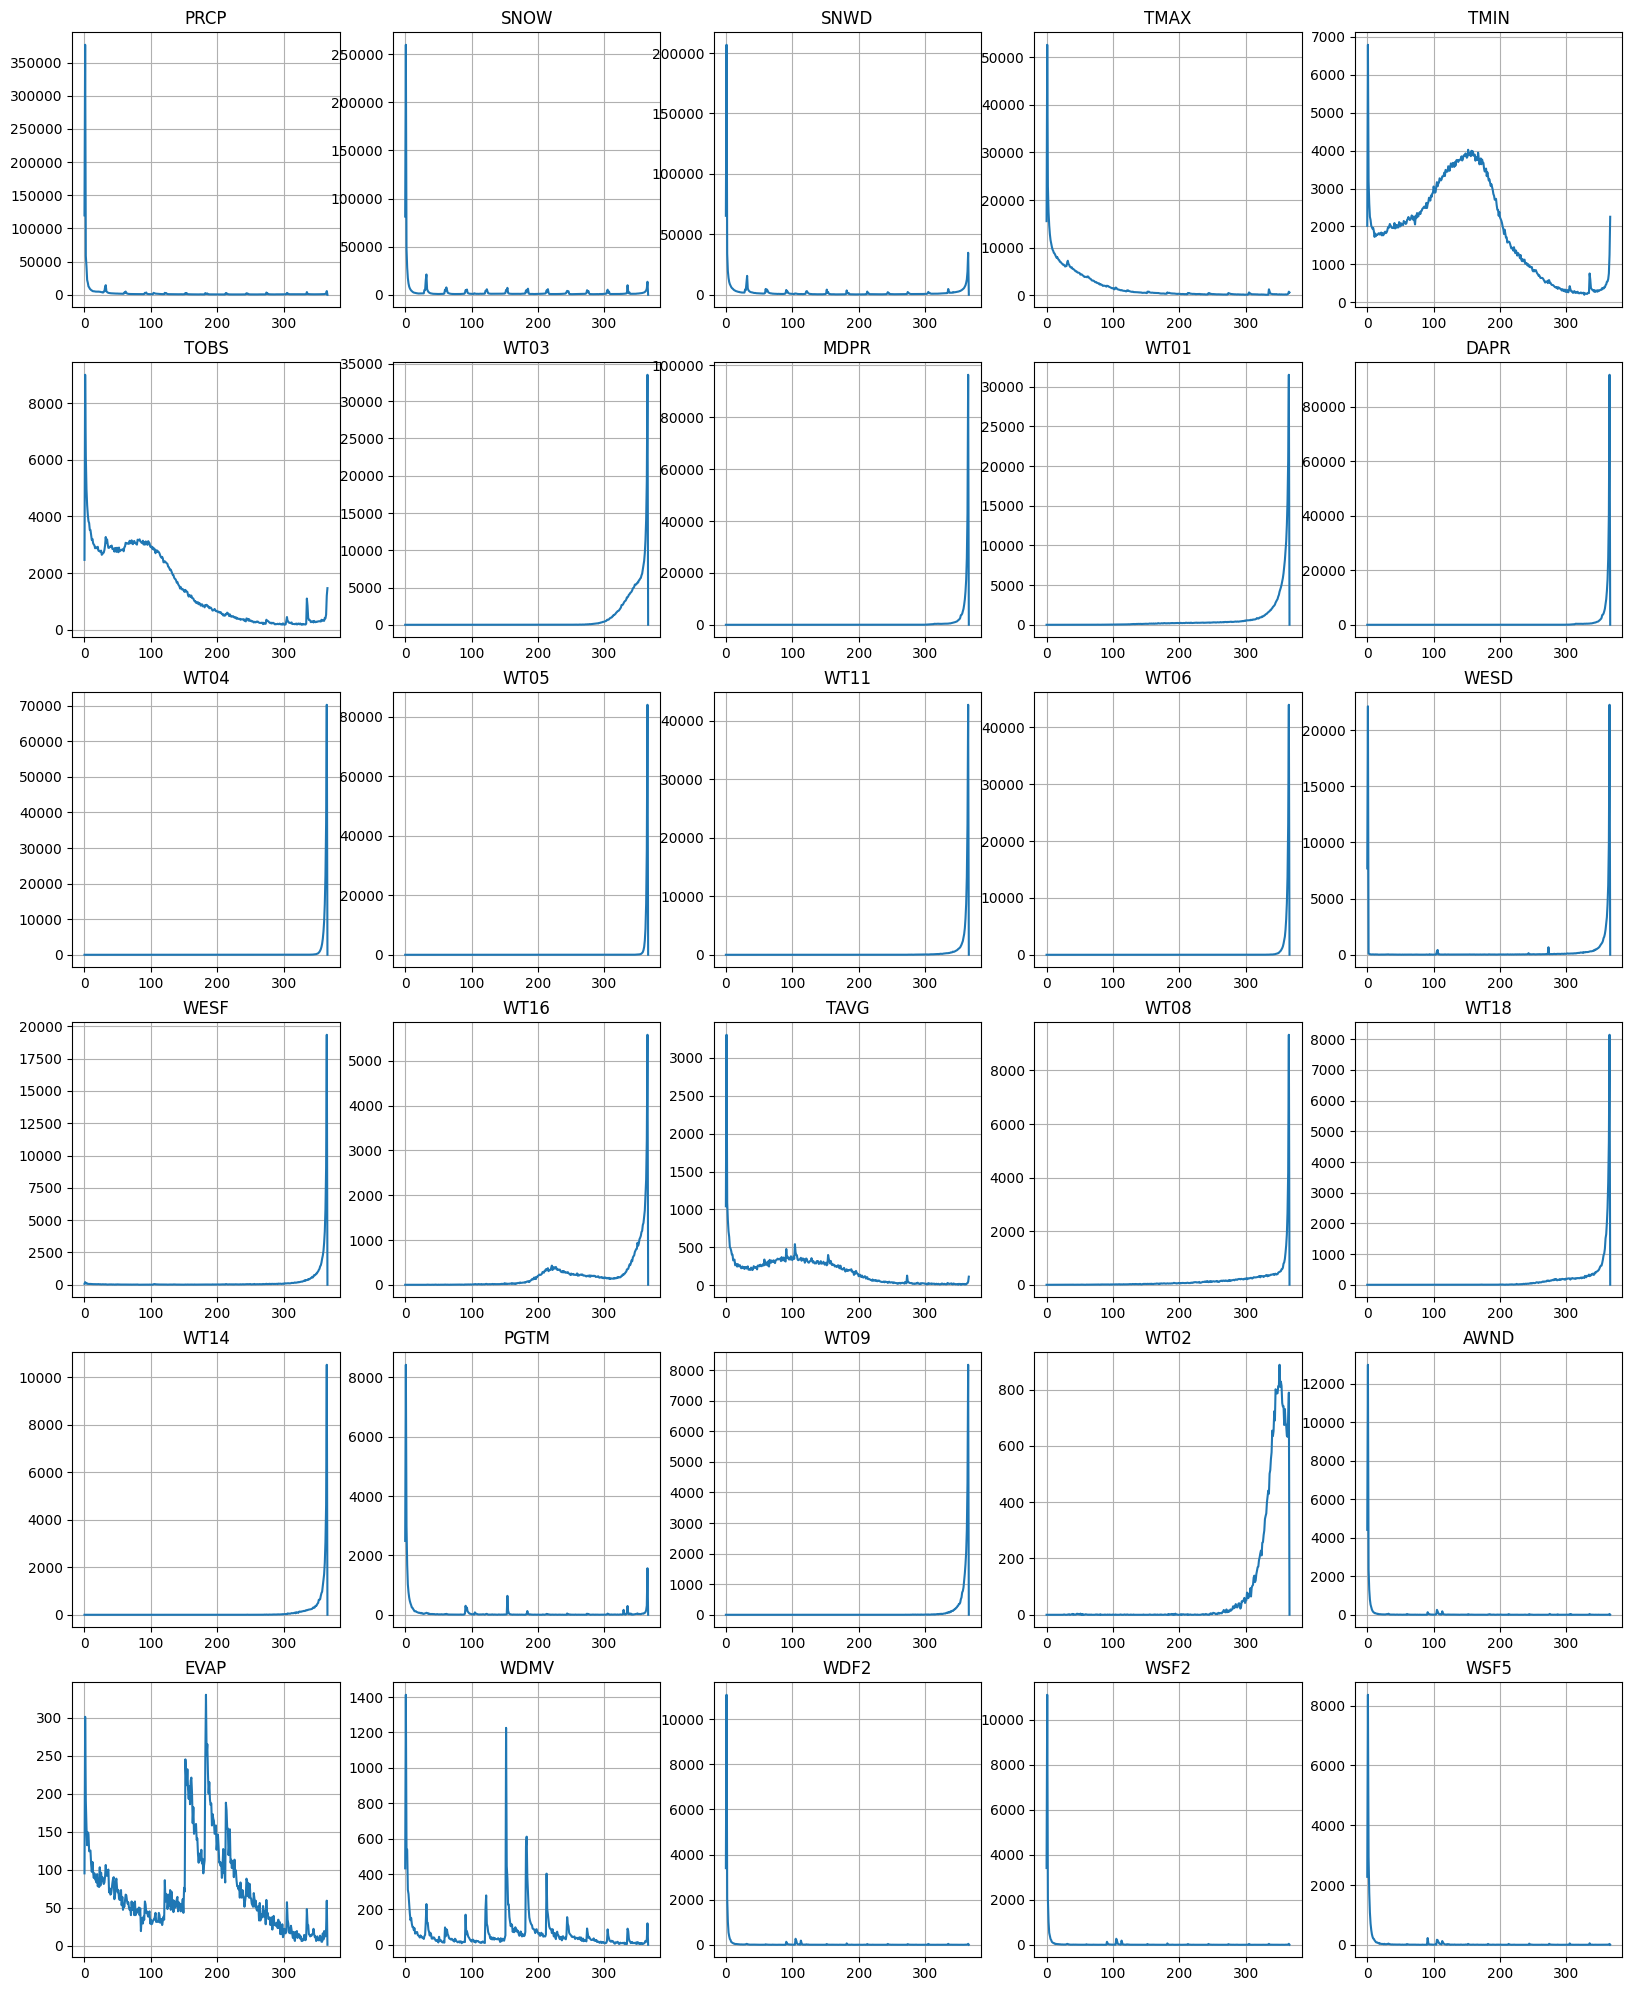

In [45]:
import matplotlib.pyplot as plt

h_dict = dict(hist)

fig, axes = plt.subplots(6, 5, figsize = (20, 25))

for i, name in enumerate(top30):
    row = i // 5
    col = i % 5
    ax = axes[row][col]
    
    ax.plot(h_dict[name])
    ax.set_title(name)
    ax.set_xticks([0, 100, 200, 300])
    ax.grid()

- Before analyzing a large dataset, it is important to know how dense it is.
- The most common measurement **PRCP** has 1.5 Million records.
- Measurements at location >=30 have fewer than 1,500 records.
- Of the 30 most common measurements, 20 have fewer than 60 defined value per year

#### To sum up

- Dataframes are an efficient way to store data tables
- All of the values in a column have same type (it's like a table column in a DB)
- A good way to store a dataframe in disk is to use a Parquet File format
- Dataframe can be manipulated declaratively, which allows for more optimization
- It's possible to refer directly to a parquet File in an SQL query